# **CoronaBERT Classification Model Evaluation**

In this notebook, I will be evaluating the performance of the CoronaBERT classification model.

## **Setup**

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

In [2]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle?raw=true

with open('/content/coronaBERT_doc_embeddings.pickle?raw=true', 'rb') as f:
  doc_embeddings = pickle.load(f)

--2022-03-15 14:38:14--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle [following]
--2022-03-15 14:38:15--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DavidONeill75101/level-4-project/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle [following]
--2022-03-15 14:38:15--  https://media.githubusercontent.com/media/DavidONeill75101/level-4-project/ma

In [3]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle?raw=true
with open('/content/coronaBERT_query_embeddings.pickle?raw=true', 'rb') as f:
  query_embeddings = pickle.load(f)

--2022-03-15 14:39:03--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle?raw=true
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle [following]
--2022-03-15 14:39:03--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle [following]
--2022-03-15 14:39:03--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/ma

In [ ]:
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
!wget https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j4.5-5.txt

--2022-02-15 15:17:54--  https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763591 (746K) [text/plain]
Saving to: ‘qrels-covid_d4_j0.5-4.txt.1’

qrels-covid_d4_j0.5 100%[===================>] 745.69K  1.15MB/s    in 0.6s    

2022-02-15 15:17:55 (1.15 MB/s) - ‘qrels-covid_d4_j0.5-4.txt.1’ saved [763591/763591]

--2022-02-15 15:17:55--  https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34087 (33K) [text/csv]
Saving to: ‘changedIds-Jul16.csv.1’

changedIds-Jul16.cs 100%[===================>]  33.29K  --.-KB/s    in 0.06s   

2022-02-15 15:17:56 (528 KB/s) - ‘changedIds-Jul16.csv.

In [ ]:
!wget https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/DataSplit/testing_data.csv
test_qrels = pd.read_csv('/content/testing_data.csv').drop(columns=['Unnamed: 0'])

--2022-02-15 16:42:54--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/DataSplit/testing_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448853 (438K) [text/plain]
Saving to: ‘testing_data.csv’

testing_data.csv    100%[===================>] 438.33K  --.-KB/s    in 0.02s   

2022-02-15 16:42:54 (20.7 MB/s) - ‘testing_data.csv’ saved [448853/448853]



In [ ]:
test_queries = list(test_qrels['qid'])
test_docnos = list(test_qrels['docno'])
test_labels = list(test_qrels['label'])



X_test = []
y_test = []

for query, docno, label in zip(test_queries, test_docnos, test_labels):
  
  try:
    query_embedding = query_embeddings[str(query)]
    doc_embedding = doc_embeddings[docno]
    input = np.concatenate([query_embedding, doc_embedding])

    X_test.append(input)
    y_test.append(label)

  except:
    print("No embedding")
  

In [ ]:
sc = StandardScaler()
X_test = sc.fit_transform(X_test)

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Models/mlpclassifier_coronaBERT.pickle?raw=true

--2022-02-15 15:20:01--  https://github.com/DavidONeill75101/level-4-project/blob/master/Models/mlpclassifier_coronaBERT.pickle?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Models/mlpclassifier_coronaBERT.pickle [following]
--2022-02-15 15:20:01--  https://github.com/DavidONeill75101/level-4-project/raw/master/Models/mlpclassifier_coronaBERT.pickle
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Models/mlpclassifier_coronaBERT.pickle [following]
--2022-02-15 15:20:01--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Models/mlpclassifier_coronaBERT.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 1

In [ ]:
classifier = pickle.load(open('/content/mlpclassifier_coronaBERT.pickle?raw=true', 'rb'))
classifier

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=1)

In [ ]:
y_true, y_pred = y_test , classifier.predict(X_test)

## **Evaluation**

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82     12239
           2       0.68      0.52      0.59      6677

    accuracy                           0.75     18916
   macro avg       0.73      0.69      0.70     18916
weighted avg       0.74      0.75      0.74     18916



In [ ]:
report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True))
print(report.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
           0 &           2 &  accuracy &    macro avg &  weighted avg \\
\midrule
    0.768753 &    0.684718 &  0.746194 &     0.726736 &      0.739090 \\
    0.869189 &    0.520743 &  0.746194 &     0.694966 &      0.746194 \\
    0.815891 &    0.591578 &  0.746194 &     0.703735 &      0.736713 \\
12239.000000 & 6677.000000 &  0.746194 & 18916.000000 &  18916.000000 \\
\bottomrule
\end{tabular}



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


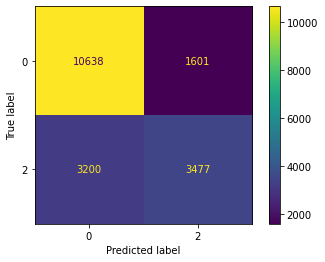

In [ ]:
plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()